### Dependencies

In [21]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import os
import glob
import shutil
import random

# Preprocessing

## Feature Scaling & File Sorting

In [2]:
# input and output directories
root_dir = '../datasets/BB-MAS_Dataset/BB-MAS_Dataset/'
output_base_dir = '../datasets/BB-MAS_Preprocessed/'

# distinguish between accelerometer and gyroscope data
sensor_types = {'Accelerometer': 'accelerometer', 'Gyroscope': 'gyroscope'}

# folders 1 - 117
for i in range(1, 118):
    folder_path = os.path.join(root_dir, str(i))
    csv_files = glob.glob(os.path.join(folder_path, '*_PocketPhone_*.csv'))
    
    if not csv_files:
        continue
    
    for csv_file in csv_files:
        df = pd.read_csv(csv_file)
        
        # copy the features that aren't being normalized then normalize to be between -1 and 1
        output_df = df[['time']].copy()
        scaler = MinMaxScaler(feature_range=(-1, 1))
        
        for column in ['Xvalue', 'Yvalue', 'Zvalue']:
            scaled_values = scaler.fit_transform(df[[column]])
            output_df[column] = scaled_values
            
        # convert timestamp to panda datetime -> calculate elapsed times -> drop original timestamp
        output_df['time'] = pd.to_datetime(output_df['time'])
        output_df['elapsed_time'] = output_df['time'].diff().dt.total_seconds().fillna(0)
        output_df.drop(columns=['time'], inplace=True)
        
        # determine sensor type for output directory
        for sensor_key, sensor_folder in sensor_types.items():
            if sensor_key in csv_file:
                sensor_output_dir = os.path.join(output_base_dir, sensor_folder)
                break
        else:
            sensor_output_dir = os.path.join(output_base_dir, 'other')
        
        # make sure folders exist and set output file names to be the input file name
        os.makedirs(sensor_output_dir, exist_ok=True)
        output_filename = os.path.basename(csv_file)
        
        # Write to file in the specific sensor type folder
        output_df.to_csv(os.path.join(sensor_output_dir, output_filename), index=False)


## Data Resize & Combination

In [26]:
# preprocessed data paths
folder_path_accelerometer = '../datasets/BB-MAS_Preprocessed/accelerometer/'
folder_path_gyroscope = '../datasets/BB-MAS_Preprocessed/gyroscope/'

# resized data paths
folder_path_accelerometer_resized = '../datasets/BB-MAS_resized/accelerometer/'
folder_path_gyroscope_resized = '../datasets/BB-MAS_resized/gyroscope/'

# resized + combined path
folder_path_combined_resized = '../datasets/BB-MAS_combined_labeled/'

# final train, validation, and test sets
folder_path_train_valid_test = '../datasets/BB-MAS_train_valid_test/'

directories = [folder_path_accelerometer, folder_path_gyroscope, folder_path_accelerometer_resized, folder_path_gyroscope_resized, folder_path_combined_resized, folder_path_train_valid_test]

for directory in directories:
    os.makedirs(directory, exist_ok=True)


### Data statistics 

In [27]:
csv_files_accelerometer = glob.glob(os.path.join(folder_path_accelerometer, '*_PocketPhone_*.csv'))
csv_files_gyroscope = glob.glob(os.path.join(folder_path_gyroscope, '*_PocketPhone_*.csv'))
rows_accelerometer = []
rows_gyroscope = []

for csv_file in csv_files_accelerometer:
    df = pd.read_csv(csv_file)
    file_name = os.path.basename(csv_file)
    rows_accelerometer.append((file_name, df.shape[0]))

for csv_file in csv_files_gyroscope:
    df = pd.read_csv(csv_file)
    file_name = os.path.basename(csv_file)
    rows_gyroscope.append((file_name, df.shape[0]))

sorted_accelerometer = sorted(rows_accelerometer, key=lambda tup: tup[1])
sorted_gyroscope = sorted(rows_gyroscope, key=lambda tup: tup[1])

# This is only to get rid of the outlier in these two
sorted_accelerometer.pop()
sorted_gyroscope.pop()

print(f'Num samples accelerometer: {len(sorted_accelerometer)}')
print(f'Num samples gyroscope: {len(sorted_gyroscope)}\n')

print(f'least number of rows in accelerometer folder: {sorted_accelerometer[0]}')
print(f'least number of rows in gyroscope folder: {sorted_gyroscope[0]}\n')

print(f'Max rows in accelerometer    : { sorted_accelerometer[-1]}')
print(f'Median rows in accelerometer : { sorted_accelerometer[len(sorted_accelerometer) // 2] }')
print(f'Average rows in accelerometer: { sum(x[1] for x in sorted_accelerometer ) // len(sorted_accelerometer)}\n')

print(f'Max rows in gyroscope    : { sorted_gyroscope[-1]}')
print(f'Median rows in gyroscope : { sorted_gyroscope[len(sorted_gyroscope) // 2] }')
print(f'Average rows in gyroscope: { sum(x[1] for x in sorted_gyroscope) // len(sorted_gyroscope) }\n')

Num samples accelerometer: 113
Num samples gyroscope: 113

least number of rows in accelerometer folder: ('104_PocketPhone_Accelerometer_(Samsung_S6).csv', 17024)
least number of rows in gyroscope folder: ('104_PocketPhone_Gyroscope_(Samsung_S6).csv', 17023)

Max rows in accelerometer    : ('85_PocketPhone_Accelerometer_(Samsung_S6).csv', 37299)
Median rows in accelerometer : ('21_PocketPhone_Accelerometer_(Samsung_S6).csv', 29590)
Average rows in accelerometer: 29087

Max rows in gyroscope    : ('85_PocketPhone_Gyroscope_(Samsung_S6).csv', 37299)
Median rows in gyroscope : ('21_PocketPhone_Gyroscope_(Samsung_S6).csv', 29590)
Average rows in gyroscope: 29087



### Zipping together files that meet size requirements

In [28]:
# Eventually cutting all data to this size
desired_size = 25000
show_dropped = False

accepted_accelerometer = []
accepted_gyroscope = []
accepted_pairs = []
i = 0
for file in sorted_accelerometer:
    if file[1] >= desired_size:
        accepted_accelerometer.append(file[0])
        csv_file_old = folder_path_accelerometer + file[0]
        csv_file_new = folder_path_accelerometer_resized + file[0]
        shutil.copyfile(csv_file_old, csv_file_new)
    else:
        if show_dropped: print(f'file \"{file[0]}\" with size {file[1]} dropped')

for file in sorted_gyroscope:
    if file[1] >= desired_size:
        accepted_gyroscope.append(file[0])
        csv_file_old = folder_path_gyroscope + file[0]
        csv_file_new = folder_path_gyroscope_resized + file[0]
        shutil.copyfile(csv_file_old, csv_file_new)
    else:
        if show_dropped: print(f'file \"{file[0]}\" with size {file[1]} dropped')
        
#print(*accepted_accelerometer, sep='\n')
accepted_pairs = zip(accepted_accelerometer, accepted_gyroscope)

#print(*accepted_pairs, sep='\n')
#print(f'{len(accepted_accelerometer)=}')
#print(f'{len(accepted_gyroscope)=}')

### Final Resize + Accelerometer and Gyroscope Combination

In [29]:
i = 1
for acc, gyro in accepted_pairs:
    # read unresized files
    df_acc  = pd.read_csv(folder_path_accelerometer_resized + acc)
    df_gyro = pd.read_csv(folder_path_gyroscope_resized + gyro)
    
    # drop elapsed time from gyro
    df_gyro = df_gyro.drop('elapsed_time', axis=1)
    
    # resize files
    df_acc  = df_acc.head(desired_size)
    df_gyro = df_gyro.head(desired_size)
    
    # renames columns
    df_acc.rename(columns={'Xvalue': 'Xvalue_acc', 'Yvalue': 'Yvalue_acc', 'Zvalue': 'Zvalue_acc'}, inplace=True)
    df_gyro.rename(columns={'Xvalue': 'Xvalue_gyro', 'Yvalue': 'Yvalue_gyro', 'Zvalue': 'Zvalue_gyro'}, inplace=True)
    
    # combine files
    combined_data = pd.concat([df_acc, df_gyro], axis=1)
    combined_data.to_csv(folder_path_combined_resized + acc , index=False)
    i += 1

### Data Labeling

In [30]:
def get_participant_number(file_path):
    base_name = os.path.basename(file_path)
    participant_number = base_name.split('_')[0]
    return participant_number

# path to your CSV file
demographics_path = '../datasets/BB-MAS_Preprocessed/Demographics.csv'
# directory containing your data files
data_path = '../datasets/BB-MAS_combined_labeled/'

# read demographics file
df = pd.read_csv(demographics_path)
# set 'User ID' as the index of the df
df.set_index('User ID', inplace=True)

# pattern match file names
csv_files = glob.glob(os.path.join(data_path, '*_PocketPhone_*.csv'))

for file in csv_files:
    userID = int(get_participant_number(file))
    if userID in df.index:
        userGender = df.loc[userID, 'Gender']
        userAge    = df.loc[userID, 'Age']
        userHeight = df.loc[userID, 'Height']
        
        # change gender to numerical binary representation
        if userGender == 'M':
            userGender = 1
        else: 
            userGender = 0
        
        # df for each participant
        participant_data = pd.read_csv(file)
        
        # add a 'UserID', 'Age', 'Height', 'Gender' columns
        participant_data['UserID'] = userID
        participant_data['Age']    = userAge
        participant_data['Height'] = userHeight
        participant_data['Gender'] = userGender
       
        
        # write the updated df back to the csv
        participant_data.to_csv(file, index=False)
        
        print(f"Adding demographics to {file} for User ID {userID}")
    else:
        print(f"User ID {userID} not found in the demographics data.")



Adding demographics to ../datasets/BB-MAS_combined_labeled/62_PocketPhone_Accelerometer_(Samsung_S6).csv for User ID 62
Adding demographics to ../datasets/BB-MAS_combined_labeled/106_PocketPhone_Accelerometer_(Samsung_S6).csv for User ID 106
Adding demographics to ../datasets/BB-MAS_combined_labeled/25_PocketPhone_Accelerometer_(Samsung_S6).csv for User ID 25
Adding demographics to ../datasets/BB-MAS_combined_labeled/46_PocketPhone_Accelerometer_(Samsung_S6).csv for User ID 46
Adding demographics to ../datasets/BB-MAS_combined_labeled/87_PocketPhone_Accelerometer_(Samsung_S6).csv for User ID 87
Adding demographics to ../datasets/BB-MAS_combined_labeled/51_PocketPhone_Accelerometer_(Samsung_S6).csv for User ID 51
Adding demographics to ../datasets/BB-MAS_combined_labeled/16_PocketPhone_Accelerometer_(Samsung_S6).csv for User ID 16
Adding demographics to ../datasets/BB-MAS_combined_labeled/90_PocketPhone_Accelerometer_(Samsung_S6).csv for User ID 90
Adding demographics to ../datasets/BB-

Adding demographics to ../datasets/BB-MAS_combined_labeled/2_PocketPhone_Accelerometer_(Samsung_S6).csv for User ID 2
Adding demographics to ../datasets/BB-MAS_combined_labeled/35_PocketPhone_Accelerometer_(Samsung_S6).csv for User ID 35
Adding demographics to ../datasets/BB-MAS_combined_labeled/56_PocketPhone_Accelerometer_(Samsung_S6).csv for User ID 56
Adding demographics to ../datasets/BB-MAS_combined_labeled/11_PocketPhone_Accelerometer_(Samsung_S6).csv for User ID 11
Adding demographics to ../datasets/BB-MAS_combined_labeled/36_PocketPhone_Accelerometer_(Samsung_S6).csv for User ID 36
Adding demographics to ../datasets/BB-MAS_combined_labeled/1_PocketPhone_Accelerometer_(Samsung_S6).csv for User ID 1
Adding demographics to ../datasets/BB-MAS_combined_labeled/115_PocketPhone_Accelerometer_(Samsung_S6).csv for User ID 115
Adding demographics to ../datasets/BB-MAS_combined_labeled/71_PocketPhone_Accelerometer_(Samsung_S6).csv for User ID 71
Adding demographics to ../datasets/BB-MAS_

### Combine all files

In [31]:
# function to read and concatenate files into a DataFrame
def files_to_df(file_list):
    dfs = [pd.read_csv(file) for file in file_list]
    return pd.concat(dfs, ignore_index=True)

In [32]:
csv_files = glob.glob(os.path.join(data_path, '*_PocketPhone_*.csv'))
random.shuffle(csv_files)  # This shuffles the order of participants, not the data within each participant

# determine split sizes, the rest goes into test
num_files = len(csv_files)
train_size = int(num_files * 0.7)
val_size = int(num_files * 0.15)

list_of_dataframes = []
for file in csv_files:
    df = pd.read_csv(file)
    list_of_dataframes.append(df)

# all files combined
combined_df = pd.concat(list_of_dataframes, ignore_index=True)

# split file paths into train, validation, and test sets
train_files = csv_files[:train_size]
val_files = csv_files[train_size:train_size + val_size]
test_files = csv_files[train_size + val_size:]


# create df for each set
train_df = files_to_df(train_files)
val_df = files_to_df(val_files)
test_df = files_to_df(test_files)

# save to CSV
train_df.to_csv(folder_path_train_valid_test + 'train_dataset.csv', index=False)
val_df.to_csv(folder_path_train_valid_test + 'val_dataset.csv', index=False)
test_df.to_csv(folder_path_train_valid_test + 'test_dataset.csv', index=False)

## Sequencing

In [ ]:
feature_columns = ['Xvalue_acc', 'Yvalue_acc', 'Zvalue_acc', 'Xvalue_gyro', 'Yvalue_gyro', 'Zvalue_gyro', 'elapsed_time']  # replace with your actual feature names
target_column = 'Gender'  
sequence_length = 100
step = 1

def create_sequences(data, feature_columns, target_column, sequence_length, step):
    sequences = []
    labels = []
    for start in range(0, len(data) - sequence_length + 1, step):
        end = start + sequence_length
        seq = data.iloc[start:end][feature_columns].values  # Extract the features for the sequence
        label = data.iloc[end - 1][target_column]  # The label is the target at the end of the sequence
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)



sequences, labels = create_sequences(train_df, feature_columns, target_column, sequence_length, step)

# Labels should be reshaped if you're going to use them in a binary crossentropy setup
labels = labels.reshape(-1, 1)

# split the sequences and labels into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(sequences, labels, test_size=0.2, random_state=42)



# LSTM Creation

### LSTM Model for Binary Classification

In [34]:
model = Sequential()
model.add(LSTM(units=64, input_shape=(sequence_length, sequences.shape[2]), return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(units=32, return_sequences=False))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))  

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 100, 64)           18432     
                                                                 
 dropout_2 (Dropout)         (None, 100, 64)           0         
                                                                 
 lstm_3 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 30881 (120.63 KB)
Trainable params: 30881 (120.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [35]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [36]:
history = model.fit(X_train, y_train, epochs=3, batch_size=32, validation_split=0.2)

Epoch 1/3
7498/7498 [==============================] - 208s 28ms/step - loss: 0.0546 - accuracy: 0.9820 - val_loss: 0.0036 - val_accuracy: 0.9993
Epoch 2/3
 921/7498 [==>...........................] - ETA: 2:49 - loss: 0.0156 - accuracy: 0.9963

KeyboardInterrupt: 

In [15]:
val_loss, val_accuracy = model.evaluate(X_val, y_val)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")


2344/2344 [==============================] - 19s 8ms/step - loss: 0.0014 - accuracy: 0.9997
Validation Loss: 0.0014212598325684667
Validation Accuracy: 0.9996932744979858


### Save Model 

In [18]:
model.save("gait_sex_classification.h5")

### Load Model

In [22]:
new_model = tf.keras.models.load_model('gait_sex_classification.keras')

# Show the model architecture
new_model.summary()

AttributeError: 'Adam' object has no attribute 'build'

## Dynamic Time Warping

In [3]:
import pandas as pd
from dtaidistance import dtw
import numpy as np

sensor1_df = pd.read_csv('../datasets/BB-MAS_Preprocessed/accelerometer/1_PocketPhone_Accelerometer_(Samsung_S6).csv')
sensor2_df = pd.read_csv('../datasets/BB-MAS_Preprocessed/gyroscope/1_PocketPhone_Gyroscope_(Samsung_S6).csv')

series1 = sensor1_df['Xvalue'].values
series2 = sensor2_df['Xvalue'].values

# perform DTW
distance, paths = dtw.warping_paths(series1, series2, window=int(max(sensor1_df['elapsed_time'])), psi=2)
best_path = dtw.best_path(paths)

print(f"DTW distance between series: {distance}")

DTW distance between series: 26.20040608905935


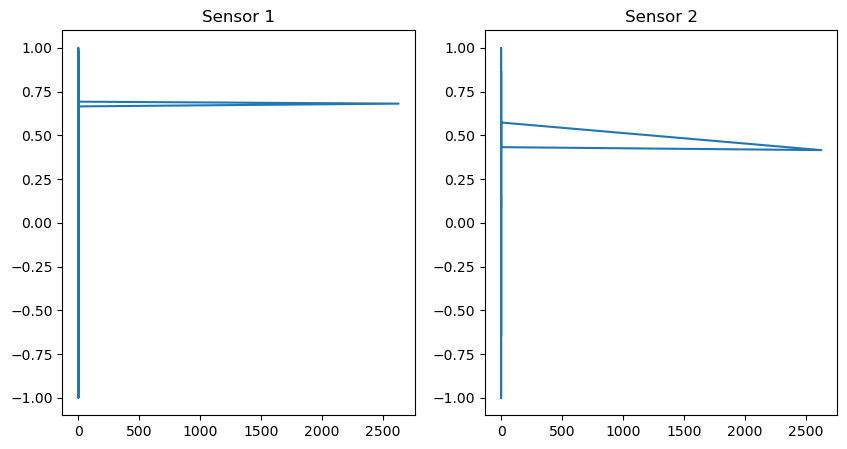

In [5]:
import matplotlib.pyplot as plt

# Visualize the path
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Sensor 1')
plt.plot(sensor1_df['elapsed_time'], series1)
plt.subplot(1, 2, 2)
plt.title('Sensor 2')
plt.plot(sensor2_df['elapsed_time'], series2)
plt.show()


## Scale Verification 

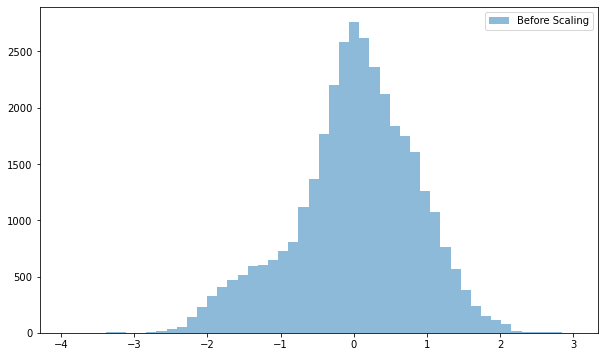

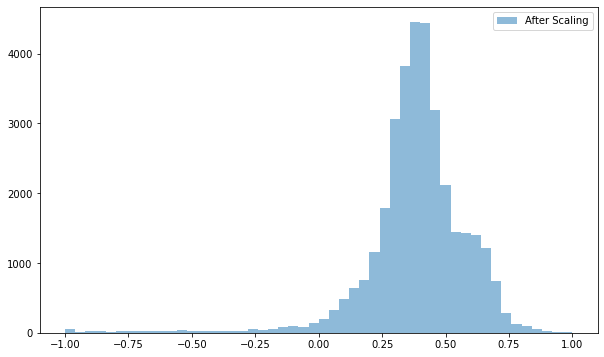

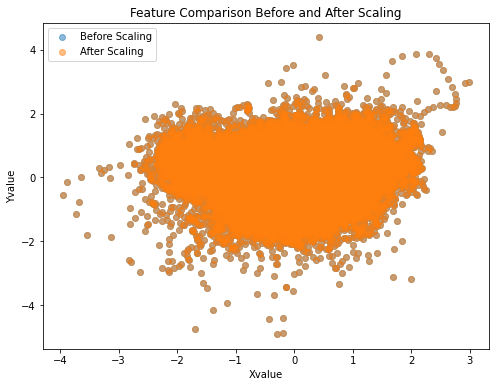

In [4]:
import matplotlib.pyplot as plt

root_dir   = '../datasets/BB-MAS_Dataset/BB-MAS_Dataset/'
output_dir = '../datasets/BB-MAS_Preprocessed/accelerometer/'

folder_path = os.path.join(root_dir, "1")
csv_files = glob.glob(os.path.join(folder_path, '*_PocketPhone_*.csv'))
scaled_files = glob.glob(os.path.join(output_dir, '1_PocketPhone_*.csv'))

df = pd.read_csv(csv_files[0])
X_train = df['Xvalue']
X_scatter = df[['Xvalue', 'Yvalue']]

df_scaled = pd.read_csv(scaled_files[0])
X_train_scaled = df_scaled['Xvalue']
X_scatter_scaled = df[['Xvalue', 'Yvalue']]

# histograms
# before scaling
plt.figure(figsize=(10, 6))
plt.hist(X_train, bins=50, alpha=0.5, label='Before Scaling')
plt.legend()
plt.show()

# after scaling
plt.figure(figsize=(10, 6))
plt.hist(X_train_scaled, bins=50, alpha=0.5, label='After Scaling')
plt.legend()
plt.show()

# scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(X_scatter['Xvalue'], X_scatter['Yvalue'], alpha=0.5, label='Before Scaling')
plt.scatter(X_scatter_scaled['Xvalue'], X_scatter_scaled['Yvalue'], alpha=0.5, label='After Scaling')
plt.title("Feature Comparison Before and After Scaling")
plt.xlabel("Xvalue")
plt.ylabel("Yvalue")
plt.legend()
plt.show()

